In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import random
import ipywidgets
import seaborn as sns
from scipy.stats import norm, uniform
import math
from math import sqrt
from dateutil.relativedelta import relativedelta #More accurate timestamp generation

# Sandbox notebook for medium article "Contextualizing..."
* Illustrations used at end of notebook
* If pictures not found in Notebook, they were created by hand in procreate using an ipad
* Blog post URL, https://medium.com/@cjc.schmidt/contextualizing-models-in-a-non-tech-organization-49c43239d349#64d0-c6632f5771b1

In [2]:
def generate_dummy_data():
        ''' 
        Random made up products   
        '''
        product_catalogue = {
            'o_ring': [0.0004, 14],
            'headphones': [20, 21],
            'monitor': [300,30],
            'laptop': [1_000, 30],
            'engine': [10_000, 120],
            'pneumatic_drill': [5_000,180],
            'cooling_unit': [20_000, 200]
        }
        return product_catalogue
product_dict = generate_dummy_data()

In [3]:
df = pd.DataFrame.from_dict(product_dict,orient='index',columns=['Unit_prices','Delivery_times_days'])

In [4]:
monthly_parameters = {
    'jan':[15,2],
    'feb':[15,2],
    'mar':[15,2],
    'apr':[15,2],
    'may':[15,2],
    'jun':[15,2],
    'jul':[15,2],
    'aug':[15,2],
    'sep':[15,2],
    'okt':[15,2],
    'nov':[15,2],
    'dec':[15,2],
}

def generate_sales(product_dict):
    '''
    Quick and dirty approach to data generation.
    '''
    item_sales = {}
    for product in product_dict:
        sales = []
        for month in monthly_parameters:

            sale = norm.rvs(loc = monthly_parameters[month][0],
                           scale=monthly_parameters[month][1],                       
                           size=1)

            sale = int(sale[0]) #Stat people, look away.
            if sale <0:
                sales.append(0)
            else: 
                sales.append(sale)
        item_sales[product] = sales

    return item_sales

def generate_timestamps():
    pass
    
    
sales = generate_sales(product_dict)

In [5]:
'''
Function to generate timestamps

start, datetime object input
step, relativedelta forward
'''
def random_timestamp(start,step=1,bucket='monthly'):    
    step=1
    if bucket=='monthly':
        future = start + relativedelta(months=+step)
        delta = future - start
        timestamp = start + (random.random() * delta)
        timestamp = timestamp.strftime('%Y-%m-%d')
    return(timestamp)

In [6]:
def generate_transactional_data(item_sales):
    picksize = [1,2,3,4,5,6]
    weights = [40,29,20,6,2.5,2.5]

    transactions = {}
    id_no= int(0)
    for item in item_sales:
        for counter, month_sale in enumerate(item_sales[item]):
            qty=0
            while qty < month_sale:
                r = random.choices(population=picksize,weights=weights)
                r = r[0] #flatten list
                if month_sale > 0:
                    if (qty + r)<= month_sale:
                        start_time = datetime.date(2020,counter+1,1) #offset zeroindex from enumerate
                        timestamp = random_timestamp(start_time)                        
                        
                        qty = qty + r
                        transactions[item, counter, id_no]={'Quantity':r,'Timestamp':timestamp}
                        id_no += 1
                else:
                    print('While loop condition incorrect, check logic')        
    return(transactions)
            
transactions = generate_transactional_data(sales) 

In [7]:
df = pd.DataFrame.from_dict(transactions,orient='index')
df.index = df.index.set_names(['Item','Month(0-11)','ID_NUMBER'])
df.reset_index(inplace=True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [8]:
mask = (df['Item']=='o_ring')
o_ring = df.loc[mask,:].copy()

In [9]:
o_ring.drop(columns=['Item','Month(0-11)','ID_NUMBER'],inplace=True)

In [10]:
o_ring.set_index('Timestamp',inplace=True)

In [11]:
myseries=o_ring.value_counts()
pick_sizes = myseries.index.get_level_values(level=0)
outcome = myseries.values

In [12]:
df_count = pd.concat([pd.Series(pick_sizes),pd.Series(outcome)],axis=1)
df_count.rename(columns={'Quantity':'Pick_sizes',0:'Frequency'},inplace=True)

<AxesSubplot:xlabel='Quantity', ylabel='count'>

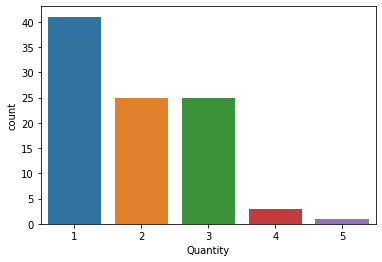

In [13]:
sns.countplot(x='Quantity',data=o_ring)

In [14]:
df_count['RelFreq']=df_count['Frequency']/df_count['Frequency'].sum(axis=0)
df_count['CumuFreq']=df_count['RelFreq'].cumsum()

In [15]:
df_count

,Pick_sizes,Frequency,RelFreq,CumuFreq
0,1,41,0.431579,0.431579
1,3,25,0.263158,0.694737
2,2,25,0.263158,0.957895
3,4,3,0.031579,0.989474
4,5,1,0.010526,1.000000


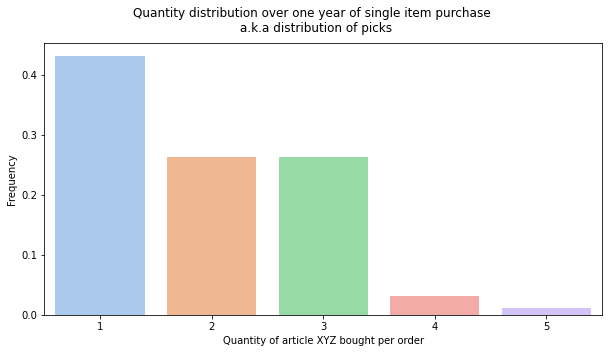

In [16]:
#sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.barplot(x='Pick_sizes',y='RelFreq',data=df_count,palette='pastel')

ax.set(ylabel='Frequency')
ax.set(xlabel='Quantity of article XYZ bought per order')
fig.suptitle('Quantity distribution over one year of single item purchase \n a.k.a distribution of picks' )
plt.savefig('Pick_distribution.png', dpi=300)
plt.show()

In [17]:
date_index2 = pd.date_range(start='2020-01-01',end='2020-12-31',freq='D')
df_daily = o_ring.resample('D').sum()
df_daily = o_ring.resample('D').sum().reindex(date_index2, fill_value=0)

In [18]:
import seaborn
df_monthly = df_daily.resample('M',label='right').sum()
df_monthly.reset_index(inplace=True)
df_monthly['Standardized']=((df_monthly['Quantity']-df_monthly['Quantity'].mean()) / df_monthly['Quantity'].std())
z_scores_sorted = df_monthly['Standardized'].sort_values(ascending=True).copy()

In [19]:
from scipy import stats 
xx = np.arange(-4,4,0.001)
yy = stats.norm.pdf(xx)
df_pdf = pd.DataFrame({'xx':xx,'yy':yy})

In [20]:
ts = o_ring.resample('D',origin='2020-01-01').sum()

In [21]:
#from math import sqrt
x = np.linspace(0,12,100)
y = x**(0.5)
df = pd.DataFrame({'x':x,'y':y})

In [22]:
df_week = df_daily.resample('W',label='right').sum()

In [23]:
mydf = pd.concat([pd.Series(df_week
               .value_counts()
               .index
               .get_level_values(level=0)
              ),
        pd.Series(df_week
                  .value_counts()
                  .values)
    ],axis=1)
mydf.rename(columns={'Quantity':'Pick_size',0:'Frequency'},inplace=True)

<AxesSubplot:xlabel='Pick_size', ylabel='Frequency'>

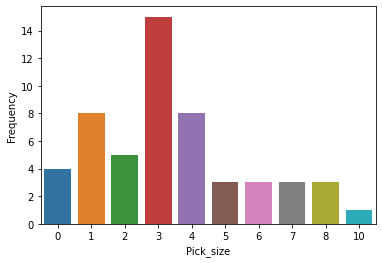

In [24]:
sns.barplot(x='Pick_size',y='Frequency', data=mydf)

In [25]:
#weekly
forecast_weekly = df_week['Quantity'].mean()
var_week = df_week['Quantity'].var()
print("Weekly forecast:",forecast_weekly, 'week variance:',var_week)

Weekly forecast: 3.452830188679245 week variance: 5.406386066763424


In [26]:
#monthly
forecast_monthly = df_monthly['Quantity'].mean()
var_monthly = df_monthly['Quantity'].var()
print("Monthly forecast:",forecast_monthly, 'var_monthly:',var_monthly)

Monthly forecast: 15.25 var_monthly: 4.568181818181818


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Unscaled sigma: 2.3251636645112583
Scaled sigma: 1.0686652677735224


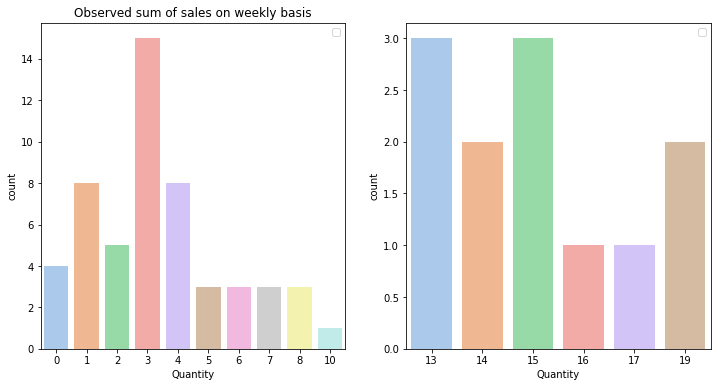

In [27]:
fig, (ax1,ax3) = plt.subplots(1,2,figsize=(12,6))

#Fourth
"ax2 = ax.twinx()"
#sns.histplot(df_week,stat='probability',label='Weekly ',ax=ax1,legend=False,alpha=0.5,bins=15)
sns.countplot(x='Quantity', data = df_week,ax=ax1,palette='pastel')
ax1.set_title('Observed sum of sales on weekly basis')
#ax1.set_xrange(0,15)
#ax1.set_xrange(0,19)
#ax1.set_xticks(np.arange(1,15,1))

#First layer - unscaled
mu = forecast_weekly
variance = var_week
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax.plot(x, stats.norm.pdf(x, mu, sigma),c='red',label='Unscaled params',lw=3,alpha=1)
print('Unscaled sigma:',sigma)

#Second layer - scaled down to 1 week coverage
mu = forecast_monthly/4
variance = var_monthly/4
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax.plot(x, stats.norm.pdf(x, mu, sigma),c='blue',label='Scaled params',lw=3,alpha=1)
print('Scaled sigma:',sigma)

#Third
#sns.histplot(df_monthly['Quantity'],stat='probability',label='Monthly',color='green',bins=8,legend=False,alpha=0.5)
sns.countplot(x='Quantity',data=df_monthly,palette='pastel')
#sns.kdeplot(mydf['Frequency'],ax=ax,label='Data generated KDE',color='green',shade=True)

ax1.legend()
ax3.legend()
plt.savefig('weekly_vs_monthly.png', dpi=300)

In [28]:
mydata = pd.DataFrame({'Time':[1,1,1,1]})
mydata.index = ['Q1','Q4','Q3','Q2']

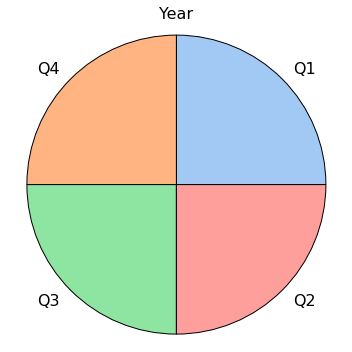

In [29]:
#plt.rcParams['font.size'] = 13.0
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', 
                                             ['#a1c9f4',
                                              '#ffb482',
                                              '#8de5a1',
                                              '#ff9f9b',
                                              '#d0bbff',
                                              '#debb9b',
                                              '#fab0e4',
                                              '#cfcfcf',
                                              '#fffea3',
                                              '#b9f2f0'])

fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.pie(mydata.loc[:,'Time'],labels=mydata.index.values,textprops={'fontsize': 16},wedgeprops={'edgecolor':'black'})
ax.axis('equal')
plt.title('Year',fontsize=16)
plt.tight_layout()
plt.savefig("Yeardist.png", dpi=300)
plt.show()

In [30]:
x = pd.Series([1,2,3,4,5,6,7,8,9,10])
y = pd.Series([1,2,1,3,12])
df =pd.DataFrame({'x':x,'y':y})

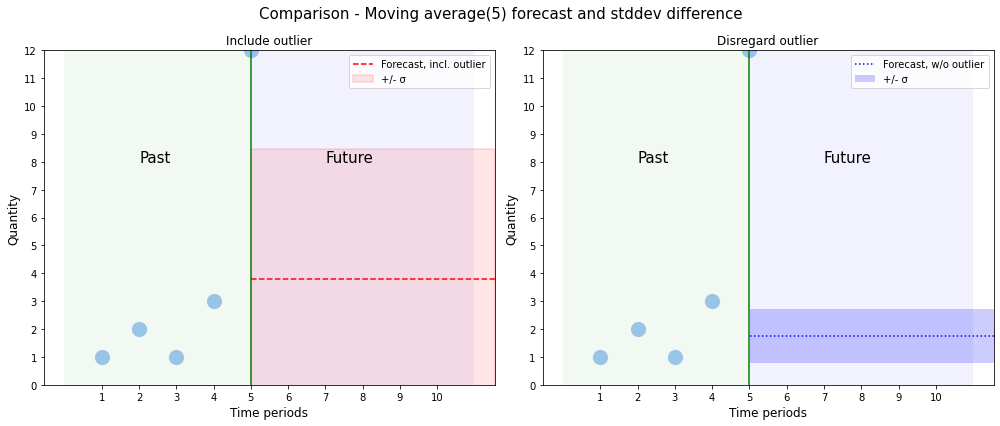

In [31]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))

y_max =int(df.loc[:,'y'].max())

#First axis
df.plot.scatter(x='x',y='y',ax=ax1,s=200)
#ax1.axhline(y=1.75, color='b', linestyle='dotted')
ax1.axhline(xmin=0.46,
            y=3.8, color='r', linestyle='--',label='Forecast, incl. outlier')
ax1.axvline(x=5, color='g', linestyle='solid')
ax1.set_xticks(df.loc[:,'x'])
ax1.set_yticks(range(0,y_max+1))


a=5
b=11
c=0
ax1.axvspan(a, b, color='blue', alpha=0.05, lw=0)
ax1.axvspan(c, a, color='green', alpha=0.05, lw=0)
ax1.text(7, 8, r'Future',size='15')
ax1.text(2, 8, r'Past',size='15')

#Adding stddev ranges
outlier_high = 3.8 + 4.658326
outlier_low = 3.8 - 4.658326
ax1.axhspan(xmin=0.46,
            ymin=outlier_low,
            ymax=outlier_high, color='red', alpha=0.1, lw=2,label='+/- σ')
ax1.set_ylim([0, 12])



#Second axis
df.plot.scatter(x='x',y='y',ax=ax2,s=200)
ax2.axhline(xmin=0.46,
            y=1.75, color='b', linestyle='dotted',label='Forecast, w/o outlier')
#ax2.axhline(y=3.8, color='r', linestyle='--')
ax2.axvline(x=5, color='g', linestyle='solid')
ax2.set_xticks(df.loc[:,'x'])
ax2.set_yticks(range(0,y_max+1))


a=5
b=11
c=0
ax2.axvspan(a, b, color='blue', alpha=0.05, lw=0)
ax2.axvspan(c, a, color='green', alpha=0.05, lw=0)
ax2.text(7, 8, r'Future',size='15')
ax2.text(2, 8, r'Past',size='15')

#Adding stddev ranges
outlier_high = 3.8 + 4.658326
outlier_low = 3.8 - 4.658326
ax2.set_ylim([0, 12])

#Non outlier
range_high = 1.75 + 0.9574271
range_low = 1.75 - 0.9574271

#xmin pct value. Just try what works
ax2.axhspan(xmin=0.46,xmax=1,
            ymin=range_low,
            ymax=range_high,
            color='blue', alpha=0.2, lw=0,label='+/- σ')


#First
ax1.set_title("Include outlier", fontsize=12) 
ax1.set_xlabel('Time periods', fontsize=12) 
ax1.set_ylabel('Quantity', fontsize=12) 
ax1.legend()

#Second
ax2.set_title("Disregard outlier", fontsize=12) 
ax2.set_xlabel('Time periods', fontsize=12) 
ax2.set_ylabel('Quantity', fontsize=12) 
ax2.legend()

#Figure
fig.suptitle('Comparison - Moving average(5) forecast and stddev difference',size=15)
plt.savefig("Outlier_comparison", dpi=300)
plt.tight_layout()
plt.show() 

In [32]:
def std_scaler(stddev,scale=1):
    #Scale defined in time unit of data capture. If data bucket is monthly, scale = 0.5 corresponds to ~2 wks.
    #whereas scale=2 corresponds to two months    
    
    scaled_std = sqrt(scale*((stddev**2)))
    return(scaled_std)

def mu_scaler(mu,scale=1):
    #Scale defined in time unit of data capture. If data bucket is monthly, scale = 0.5 corresponds to ~2 wks.
    #whereas scale=2 corresponds to two months    
    scaled_mu = mu*scale
    return(scaled_mu)

In [33]:
mu_clean = 1.75
std_clean = 0.9574271

mu_outlier = 3.8
std_outlier = 4.658326


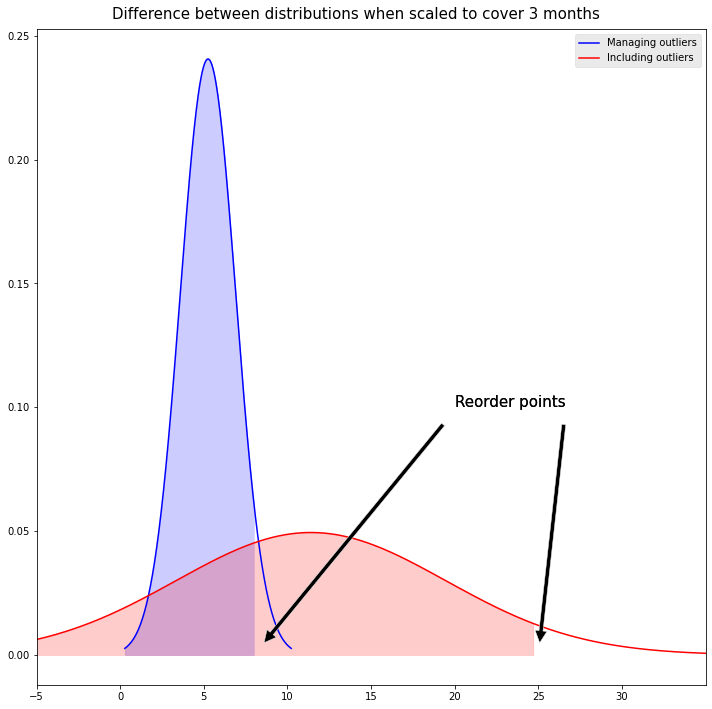

In [34]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.style.use('ggplot')

#Leadtime 3 months
loc_outlier = mu_scaler(mu_outlier,scale=3)
scale_outlier = std_scaler(std_outlier,scale=3)


loc = mu_scaler(mu_clean,scale=3)
scale = std_scaler(std_clean,scale=3)

#non outlier prob.dist
x = np.linspace(loc - 3*scale, loc+3*scale, 1000)
iq=stats.norm(loc,scale)
plt.plot(x,iq.pdf(x),'b',label='Managing outliers')

px=np.arange(loc-3*scale,loc+1.65*scale,0.01)
plt.fill_between(px,iq.pdf(px),color='blue',alpha=0.2)

#outlier prob dist

x = np.linspace(loc_outlier - 3*scale_outlier, loc_outlier+3*scale_outlier, 1000)
iq=stats.norm(loc_outlier,scale_outlier)
plt.plot(x,iq.pdf(x),'r',label='Including outliers')

px=np.arange(loc_outlier-3*scale_outlier,loc_outlier+1.65*scale_outlier,0.01)
plt.fill_between(px,iq.pdf(px),color='red',alpha=0.2)


#Overlap 2x arrows
ax.annotate('Reorder points',fontsize=15 ,xy=(8, 0), xytext=(20, 0.1),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
ax.annotate('Reorder points',fontsize=15 ,xy=(25, 0), xytext=(20, 0.1),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
##################

plt.xticks([i for i in range(-10,35,5)])
plt.xlim(-5,35)
plt.legend()
fig.suptitle('Difference between distributions when scaled to cover 3 months',size=15)

plt.savefig("Distribution_Forecast_diff", dpi=300)
plt.tight_layout()
plt.show()




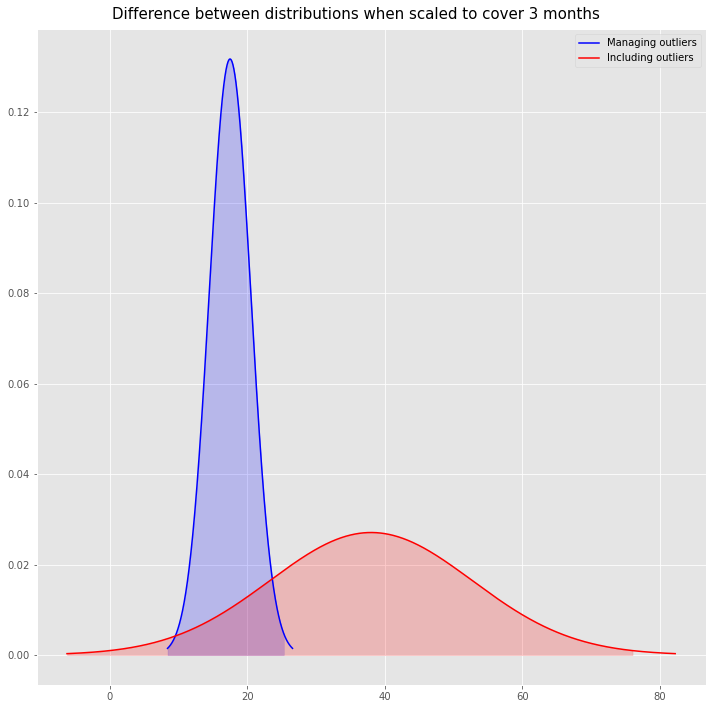

In [35]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.style.use('ggplot')

#Leadtime 3 months
loc_outlier = mu_scaler(mu_outlier,scale=10)
scale_outlier = std_scaler(std_outlier,scale=10)


loc = mu_scaler(mu_clean,scale=10)
scale = std_scaler(std_clean,scale=10)

#non outlier prob.dist
x = np.linspace(loc - 3*scale, loc+3*scale, 1000)
iq=stats.norm(loc,scale)
plt.plot(x,iq.pdf(x),'b',label='Managing outliers')

px=np.arange(loc-3*scale,loc+2.58*scale,0.01)
plt.fill_between(px,iq.pdf(px),color='blue',alpha=0.2)

#outlier prob dist

x = np.linspace(loc_outlier - 3*scale_outlier, loc_outlier+3*scale_outlier, 1000)
iq=stats.norm(loc_outlier,scale_outlier)
plt.plot(x,iq.pdf(x),'r',label='Including outliers')

px=np.arange(loc_outlier-3*scale_outlier,loc_outlier+2.58*scale_outlier,0.01)
plt.fill_between(px,iq.pdf(px),color='red',alpha=0.2)



plt.legend()
fig.suptitle('Difference between distributions when scaled to cover 3 months',size=15)

plt.savefig("Distribution_Forecast_diff", dpi=300)
plt.tight_layout()
plt.show()


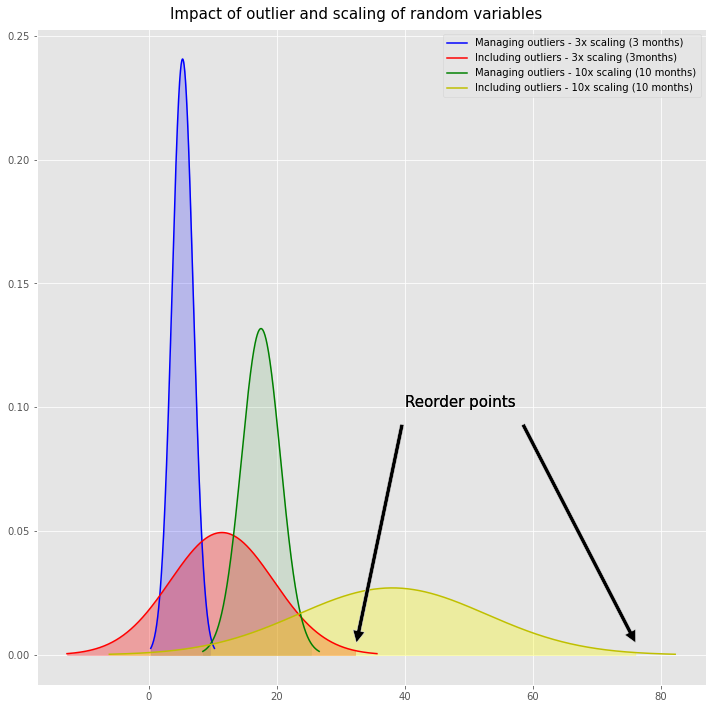

In [36]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.style.use('ggplot')

#Leadtime 3 months
loc_outlier = mu_scaler(mu_outlier,scale=3)
scale_outlier = std_scaler(std_outlier,scale=3)


loc = mu_scaler(mu_clean,scale=3)
scale = std_scaler(std_clean,scale=3)

#non outlier prob.dist
x = np.linspace(loc - 3*scale, loc+3*scale, 1000)
iq=stats.norm(loc,scale)
plt.plot(x,iq.pdf(x),'b',label='Managing outliers - 3x scaling (3 months)')

px=np.arange(loc-3*scale,loc+2.58*scale,0.01)
plt.fill_between(px,iq.pdf(px),color='blue',alpha=0.2)

#outlier prob dist

x = np.linspace(loc_outlier - 3*scale_outlier, loc_outlier+3*scale_outlier, 1000)
iq=stats.norm(loc_outlier,scale_outlier)
plt.plot(x,iq.pdf(x),'r',label='Including outliers - 3x scaling (3months)')

px=np.arange(loc_outlier-3*scale_outlier,loc_outlier+2.58*scale_outlier,0.01)
plt.fill_between(px,iq.pdf(px),color='red',alpha=0.3)

#Leadtime 3 months
loc_outlier = mu_scaler(mu_outlier,scale=10)
scale_outlier = std_scaler(std_outlier,scale=10)


loc = mu_scaler(mu_clean,scale=10)
scale = std_scaler(std_clean,scale=10)

#non outlier prob.dist
x = np.linspace(loc - 3*scale, loc+3*scale, 1000)
iq=stats.norm(loc,scale)
plt.plot(x,iq.pdf(x),'g',label='Managing outliers - 10x scaling (10 months)')

px=np.arange(loc-3*scale,loc+2.58*scale,0.01)
plt.fill_between(px,iq.pdf(px),color='green',alpha=0.1)

#outlier prob dist

x = np.linspace(loc_outlier - 3*scale_outlier, loc_outlier+3*scale_outlier, 1000)
iq=stats.norm(loc_outlier,scale_outlier)
plt.plot(x,iq.pdf(x),'y',label='Including outliers - 10x scaling (10 months)')

px=np.arange(loc_outlier-3*scale_outlier,loc_outlier+2.58*scale_outlier,0.01)
plt.fill_between(px,iq.pdf(px),color='yellow',alpha=0.3)

#Overlap 2x arrows
ax.annotate('Reorder points',fontsize=15 ,xy=(32, 0), xytext=(40, 0.1),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
ax.annotate('Reorder points',fontsize=15 ,xy=(77, 0), xytext=(40, 0.1),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
##################

plt.legend()
fig.suptitle('Impact of outlier and scaling of random variables',size=15)
plt.savefig("Distribution_Forecast_diff_scaling", dpi=300)
plt.tight_layout()
plt.show()
